# Анализ базы данных сервиса для чтения книг

**Цель исследования** - проанализировать базу данных сервиса для чтения книг по подписке для формулирования ценностного предложения для нового продукта.

**Ход исследования**

Данные для анализа находятся в базе данных, в которой содержится информация о книгах, издательствах, авторах, а также пользовательские обзоры книг. Будет проведён обзор таблиц из базы данных, после чего каждый ключевой параметр будет проанализирован - будут установлены актуальный ассортимент книг, количество обзоров и средняя оценку, наиболее крупные издательства и успешные авторы, а также будут выявлены наиболее активные пользователи самого сервиса. По результатам будет сформирован общий вывод.

Таким образом, исследование пройдёт в следующих этапах:

1. [**Обзор данных**](#1)
2. [**Анализ базы данных**](#2)
3. [**Общий вывод**](#3)

В ходе исследования в качестве инструментов работы с данными будут использованы следующие библиотеки Python:

- `Pandas` - для вывода и хранения данных

- `SQLAlchemy` - для запросов к БД
___
<a id='DB'></a>
**Схема базы данных**

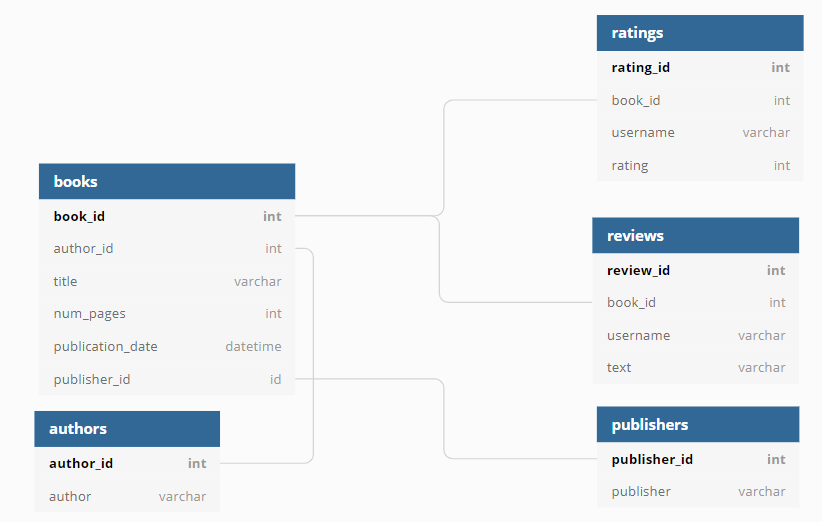

<a id='1'></a>
## Обзор данных
Изучим каждую таблицу по отдельности

In [1]:
# импортируем библиотеки для работы с данными

import pandas as pd 
from sqlalchemy import create_engine 

In [2]:
# устанавливаем параметры подключения к БД

db_config = {'user': '###', # имя пользователя (скрыто)
'pwd': '###', # пароль (скрыто)
'host': 'rc1b-wcoijxj3yxfsf3fs.mdb.yandexcloud.net', 
'port': 6432, # порт подключения
'db': 'data-analyst-final-project-db'} # название базы данных
connection_string = 'postgresql://{}:{}@{}:{}/{}'.format(db_config['user'], 
 db_config['pwd'], 
 db_config['host'], 
 db_config['port'], 
 db_config['db']) 

# сохраняем коннектор

engine = create_engine(connection_string, connect_args={'sslmode':'require'}) 

In [3]:
# напишем функцию для обзора таблиц

def overview(table):
    
    df = pd.io.sql.read_sql_table(table, con = engine)
    
    df.info()
    display(df.sample(5, random_state=0), df.describe(include='object'))
    print(f'duplicated rows - {df.duplicated().sum()}')

### Таблица с данными о книгах

In [4]:
# выводим общую информацию и несколько случайных строк

overview('books')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   book_id           1000 non-null   int64         
 1   author_id         1000 non-null   int64         
 2   title             1000 non-null   object        
 3   num_pages         1000 non-null   int64         
 4   publication_date  1000 non-null   datetime64[ns]
 5   publisher_id      1000 non-null   int64         
dtypes: datetime64[ns](1), int64(4), object(1)
memory usage: 47.0+ KB


,book_id,author_id,title,num_pages,publication_date,publisher_id
993,994,408,World War Z: An Oral History of the Zombie War,342,2006-09-12,68
859,860,425,The Scarlet Letter,279,2003-02-27,212
298,299,236,Harry Potter and the Chamber of Secrets (Harry...,341,1999-06-02,24
553,554,67,Scott Pilgrim Volume 1: Scott Pilgrim's Preci...,168,2004-08-18,196
672,673,235,The Catcher in the Rye,277,2001-01-30,31


,title
count,1000
unique,999
top,Memoirs of a Geisha
freq,2


duplicated rows - 0


___
**Таблица `books`** содержит 1000 строк и 6 столбцов. Согласно схеме БД, поле `book_id` является первичным ключём таблице, внешними ключами для связи с другими таблицами являются поля `author_id` и `publisher_id`. Явные пропуски отсутствуют, даты представлены в корректном формате, что может позволить делать часть запросов к БД без дополнительного преобразования. Полностью задублированные строки отсутствуют, но при этом одно из названий книг встречается в таблице дважды - возможно это переиздание или другая версия книги. В связи с этим в ходе исследования при группировке данных в ходе исследования необходимо использовать уникальный идентификатор вместо названия.
___
**Описание данных из документации**:

- `book_id` — идентификатор книги;
- `author_id` — идентификатор автора;
- `title` — название книги;
- `num_pages` — количество страниц;
- `publication_date` — дата публикации книги;
- `publisher_id` — идентификатор издателя.
___

### Таблица с данными об авторах

In [5]:
# выводим общую информацию и несколько случайных строк

overview('authors')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 636 entries, 0 to 635
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author_id  636 non-null    int64 
 1   author     636 non-null    object
dtypes: int64(1), object(1)
memory usage: 10.1+ KB


,author_id,author
453,454,Orson Scott Card/Piotr W. Cholewa
482,483,Primo Levi/Stuart J. Woolf/Philip Roth
516,517,Rohinton Mistry
542,543,Stephen King/Bernie Wrightson
85,86,Charles Dickens/Nicola Bradbury/Hablot Knight ...


,author
count,636
unique,636
top,A.S. Byatt
freq,1


duplicated rows - 0


<a id='anomaly'></a>
___
**Таблица `authors`** содержит 636 строк и 2 столбца. Согласно [*схеме БД*](#DB), поле `author_id` является первичным ключём таблицы. Явных пропусков нет и полностью задублированных строк нет, но данные потенциально могут содержать неявные дубликаты - например, в поле с уникальным идентификатором автора `543` можно увидеть запись `Stephen King/Bernie Wrightson`, что может означать соавторство этих двух писателей. Но при этом [**Bernie Wrightson**](https://en.wikipedia.org/wiki/Bernie_Wrightson) не книжный писатель - он является художником и автором комиксов, известным в том числе благодоря созданию иллюстрации для книг авторста [**Stephen King**]( https://en.wikipedia.org/wiki/Stephen_King). В таком случае книга с таким `author_id` на самом деле должна относится к книгам Стивена Кинга, но она не будет учтена при группировке данных по уникальному имени или идентификатору автора.
___
**Описание данных из документации**:

- `author_id` — идентификатор автора;
- `author` — имя автора.

___

### Таблица с данными об издательствах

In [6]:
# выводим общую информацию и несколько случайных строк

overview('publishers')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 340 entries, 0 to 339
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   publisher_id  340 non-null    int64 
 1   publisher     340 non-null    object
dtypes: int64(1), object(1)
memory usage: 5.4+ KB


,publisher_id,publisher
225,226,Plume
271,272,Simon & Schuster Simon Pulse
204,205,Pan Childrens
274,275,Simon Schuster
299,300,Turtleback


,publisher
count,340
unique,340
top,Ace
freq,1


duplicated rows - 0


___
**Таблица `publishers`** содержит 340 строк и 2 столбца. Согласно [*схеме БД*](#DB), поле `publisher_id` является первичным ключём таблицы.

Описание данных из документации:

- `publisher_id` — идентификатор издательства;
- `publisher` — название издательства;
___

### Таблица с данными о пользовательских оценках

In [7]:
# выводим общую информацию и несколько случайных строк

overview('ratings')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6456 entries, 0 to 6455
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   rating_id  6456 non-null   int64 
 1   book_id    6456 non-null   int64 
 2   username   6456 non-null   object
 3   rating     6456 non-null   int64 
dtypes: int64(3), object(1)
memory usage: 201.9+ KB


,rating_id,book_id,username,rating
5434,5435,838,debra43,4
4215,4216,677,edwardbrown,4
2232,2233,359,wknight,4
4583,4584,722,amymckenzie,4
4312,4313,692,jasongoodman,3


,username
count,6456
unique,160
top,martinadam
freq,56


duplicated rows - 0


___
**Таблица `ratings`** содержит 6,456 строк и 4 столбца. При этом все оценки выставили всего 160 уникальных пользователей. Согласно [*схеме БД*](#DB), поле `rating_id` является первичным ключём таблице, внешним ключом для связи с другими таблицами является `book_id`. 

Описание данных из документации:

- `rating_id` — идентификатор оценки;
- `book_id` — идентификатор книги;
- `username` — имя пользователя, оставившего оценку;
- `rating` — оценка книги.

### Таблица с данными о пользовательских обзорах книг

In [8]:
# выводим общую информацию и несколько случайных строк

overview('reviews')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2793 entries, 0 to 2792
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review_id  2793 non-null   int64 
 1   book_id    2793 non-null   int64 
 2   username   2793 non-null   object
 3   text       2793 non-null   object
dtypes: int64(2), object(2)
memory usage: 87.4+ KB


,review_id,book_id,username,text
1533,1532,556,roberto26,People floor assume like new knowledge yet. Re...
2392,2392,860,fharris,Walk would relate worker two because financial...
502,788,292,nicoleburns,Bag early hotel. Foot fly quality.
1515,1514,549,ryanfranco,Hit hotel meet through cause standard behind. ...
1858,1857,674,edwardbrown,Change forward during current. Writer ready po...


,username,text
count,2793,2793
unique,160,2793
top,susan85,Mention society tell send professor analysis. ...
freq,29,1


duplicated rows - 0


___
**Таблица `reviews`** содержит 2,793 строк и 4 столбца. Согласно [*схеме БД*](#DB), поле `review_id` является первичным ключём таблице, внешним ключом для связи с другими таблицами является `book_id`. Набор полей практически полностью совпадает с таблицей `ratings`, что ставит под вопрос целесообразность использования двух разных таблиц для хранения данных. Количество уникальных `username` также совпадает - вероятно что это одни и те же пользователи.
___
**Описание данных из документации**:

- `review_id` — идентификатор обзора;
- `book_id` — идентификатор книги;
- `username` — имя пользователя, написавшего обзор;
- `text` — текст обзора.

___

### Итоги

В ходе обзора было настроено подлючение к БД, после чего каждая таблица была проанализирована на предмет наличия пропусков и корректности типа хранимых данных.
___

Краткое резюме обзора:

- **Таблица `books`** содержит 1000 строк и 6 столбцов. Согласно схеме БД, поле `book_id` является первичным ключём таблице, внешними ключами для связи с другими таблицами являются поля `author_id` и `publisher_id`. Явные пропуски отсутствуют, даты представлены в корректном формате, что может позволить делать часть запросов к БД без дополнительного преобразования. Полностью задублированные строки отсутствуют, но при этом одно из названий книг встречается в таблице дважды - возможно это переиздание или другая версия книги. В связи с этим в ходе исследования при группировке данных в ходе исследования необходимо использовать уникальный идентификатор вместо названия.


- **Таблица `authors`** содержит данные об авторах, состоит из 636 строк и 2 столбцов. Поле `author_id` является первичным ключём таблицы. Явных пропусков нет, но данные потенциально могут содержать неявные дубликаты - например, в поле с уникальным идентификатором автора `543` можно увидеть запись `Stephen King/Bernie Wrightson`, что может означать соавторство этих двух писателей. Но при этом [**Bernie Wrightson**](https://en.wikipedia.org/wiki/Bernie_Wrightson) не книжный писатель - он является художником и автором комиксов, известным в том числе благодоря созданию иллюстрации для книг авторста [**Stephen King**]( https://en.wikipedia.org/wiki/Stephen_King). В таком случае книга с таким `author_id` на самом деле должна относится к книгам Стивена Кинга, но она не будет учтена при группировке данных по уникальному имени или идентификатору автора.


- **Таблица `publishers`** содержит данные об издательствах, состоит из 340 строк и 2 столбцов. Поле `publisher_id` является первичным ключём таблицы.


- **Таблица `ratings`** содержит данные о пользовательских оценках книг, состоит из 6,456 строк и 4 столбцов. При этом все оценки выставили всего 160 уникальных пользователей. Поле `rating_id` является первичным ключём таблице, внешним ключом для связи с другими таблицами является `book_id`.


- **Таблица `reviews`** содержит данные о пользовательских обзорах на книги, состоит из 2,793 строк и 4 столбцов. Поле `review_id` является первичным ключём таблице, внешним ключом для связи с другими таблицами является `book_id`. Набор полей практически полностью совпадает с таблицей `ratings`, что ставит под вопрос целесообразность использования двух разных таблиц для хранения данных. Количество уникальных `username` также совпадает - вероятно что это одни и те же пользователи.
___

<a id='2'></a>
## Анализ базы данных

Исследование базы данных будет поделено на следующие этапы:

- [**Установление размера актуального ассортимента книг**](#2.1)
- [**Анализ количества обзоров и средней оценки книг**](#2.2)
- [**Определение книжных издателей**](#2.3)
- [**Выделение наиболее успешных авторов книг**](#2.4)
- [**Анализ наиболее активных пользователей**](#2.5)

<a id='2.1'></a>
### Установление размера актуального ассортимента книг

Посчитаем, сколько книг вышло после 1 января 2000 года:

In [9]:
# формируем запрос к БД
# используем данные таблицы 'books'

query = ('''

SELECT COUNT(book_id) as books_count
FROM books
WHERE DATE_TRUNC('day', CAST(publication_date AS timestamp)) > '2000-01-01';

''')

# выводим результат

pd.io.sql.read_sql(query, con = engine) 

,books_count
0,819


- В таблице содержится 819 уникальных книг, выпущенных после 01.01.2001, что составляет более 80% всего ассортимента - это указывает на новизну и актульность большей части каталога.

<a id='2.2'></a>
### Анализ количества обзоров и средней оценки книг
Для каждой книги посчитаем количество обзоров и среднюю оценку:


In [10]:
# используем данные таблиц 'ratings' и 'reviews'
# так названия книг дублируются, для группировки используем уникальный идентификатор

query = ('''

SELECT b.title AS book_title,
       COUNT(DISTINCT review_id) AS reviews_count,
       ROUND(AVG(rt.rating), 2) AS average_rating
FROM books AS b
LEFT JOIN reviews AS rv on b.book_id=rv.book_id
LEFT JOIN ratings AS rt on b.book_id=rt.book_id
GROUP BY b.book_id
ORDER BY reviews_count DESC;

''')

# выводим результат

pd.io.sql.read_sql(query, con = engine) 

,book_title,reviews_count,average_rating
0,Twilight (Twilight #1),7,3.66
1,Water for Elephants,6,3.98
2,The Glass Castle,6,4.21
3,Harry Potter and the Prisoner of Azkaban (Harr...,6,4.41
4,The Curious Incident of the Dog in the Night-Time,6,4.08
...,...,...,...
995,Anne Rice's The Vampire Lestat: A Graphic Novel,0,3.67
996,The Natural Way to Draw,0,3.00
997,The Cat in the Hat and Other Dr. Seuss Favorites,0,5.00
998,Essential Tales and Poems,0,4.00


- В данных не просмотривается корреляция средней оценки и количества отзывов - большая популярность книги вовсе не означает высокий рейтинг и наоборот, не у всех высокооценённых книг есть отзывы от пользователей.

<a id='2.3'></a>
### Определение книжных издателей
Определим издательство, которое выпустило наибольшее число книг толще 50 страниц — так мы исключим из анализа брошюры:

In [11]:
# используем таблицы 'books' и 'publisher'

query = ('''

SELECT p.publisher,
       COUNT(b.book_id) AS books_count    
FROM publishers as p
JOIN books AS b ON p.publisher_id=b.publisher_id
WHERE b.num_pages > 50
GROUP BY p.publisher
ORDER BY books_count DESC
LIMIT 1
''')

# выводим результат

pd.io.sql.read_sql(query, con = engine) 

,publisher,books_count
0,Penguin Books,42


- Компания `Penguin Books` является крупнейшим книжным издателем - они выпустили 42 книги, что составляет около 5% от всего каталога.

<a id='2.4'></a>
### Выделение наиболее успешных авторов книг
Определим автора с самой высокой средней оценкой книг — учтём только книги с 50 и более оценками:


In [12]:
# формируем запрос с помощью временной таблицы 

query = ('''

WITH top AS (SELECT b.book_id,
                    ROUND(AVG(rating), 2) AS avg_rating
             FROM books AS b
             LEFT JOIN ratings AS rt ON b.book_id=rt.book_id
             LEFT JOIN authors AS a ON b.author_id=a.author_id
             GROUP BY b.book_id
             HAVING COUNT(rt.rating_id) >= 50)

SELECT a.author,
       ROUND(AVG(top.avg_rating), 2) AS avg_rating
FROM authors AS a
JOIN books AS b ON a.author_id=b.author_id
RIGHT JOIN top ON b.book_id=top.book_id
GROUP BY a.author
ORDER BY avg_rating DESC
LIMIT 1

''')

# выводим результат

pd.io.sql.read_sql(query, con = engine) 

,author,avg_rating
0,J.K. Rowling/Mary GrandPré,4.29


- Самым высоким средним рейтингом книг, оценённых более 50 раз, обладает писательница [**J.K. Rowling**](https://en.wikipedia.org/wiki/J._K._Rowling). В поле базы данных она записана вместе с [**Mary GrandPré**](https://en.wikipedia.org/wiki/Mary_GrandPr%C3%A9), которая является иллюстратором - ситуация [**аналогична наблюдению из обзора данных.**](#anomaly)

<a id='2.5'></a>
### Анализ наиболее активных пользователей
Посчитаем среднее количество обзоров от пользователей, которые поставили больше 50 оценок:

In [13]:
# формируем запрос к БД

query = ('''

WITH 
users AS (SELECT  username,
                       COUNT(rating_id) AS ratings_count
               FROM ratings
               GROUP BY username
               HAVING COUNT(rating_id) > 50),
reviewers AS (SELECT username,
                     COUNT(review_id) AS reviews
                     FROM reviews
                     GROUP BY username)

SELECT ROUND(SUM(r.reviews)/COUNT(u.username), 2) AS avg_review_count
FROM users AS u
JOIN reviewers AS r ON u.username=r.username


''')

# выводим результат

pd.io.sql.read_sql(query, con = engine) 

,avg_review_count
0,24.33


- Пользователи, оценившие более 50 фильмов, оставляют в среднем около 24 рецензий, другими словами - каждый второй оценённый фильм.

<a id='3'></a>
## Общий вывод

___
**Рекомендации**

-  При группировке данных по идентификатору или имени автора некоторые позиции могут не учитываться из-за выделения нескольких авторов(а иногда - иллюстраторов) в отдельный уникальный идпентификатор автора. В связи с этим необходимо исключить выделение соавторства нескольких писателей в отдельный идентификатор, для чего рекомендуется пересмотреть связь таблиц с информацией о книгах и авторах (например, реализовать связь вида "*many-to-many*") или произвести их объединение. Также данные людей, принимавашие участие в создании книги, но являвшихся писателями, следует хранить в отдельном поле.


- Использование двух разных таблиц для хранения отзывов и оценок нецелесообразно, так как информация в них по большей части совпадает. Рекомендуется рассмотреть объединение этих таблиц для оптимизации последующих аналитических исследований.

Целью исследования являлся анализ базы данных для формулирования ценностного предложения для нового продукта.

Данные для анализа находились я в базе данных, в которой содержится информация о книгах, издательствах, авторах, а также пользовательские обзоры книг. Был проведён обзор таблиц из базы данных, после чего каждый ключевой параметр был проанализирован - был установлены актуальный ассортимент книг, количество обзоров и средняя оценку, наиболее крупные издательства и успешные авторы, а также будут выявлены наиболее активные пользователи самого сервиса.

Таким образом, исследование прошло в следующих этапах:

1. [**Обзор данных**](#1)

В ходе обзора было настроено подлючение к БД, после чего каждая таблица была проанализирована на предмет наличия пропусков и корректности типа хранимых данных.
___

Краткое резюме обзора:

- **Таблица `books`** содержит 1000 строк и 6 столбцов. Согласно схеме БД, поле `book_id` является первичным ключём таблице, внешними ключами для связи с другими таблицами являются поля `author_id` и `publisher_id`. Явные пропуски отсутствуют, даты представлены в корректном формате, что может позволить делать часть запросов к БД без дополнительного преобразования. Полностью задублированные строки отсутствуют, но при этом одно из названий книг встречается в таблице дважды - возможно это переиздание или другая версия книги. В связи с этим в ходе исследования при группировке данных в ходе исследования необходимо использовать уникальный идентификатор вместо названия.


- **Таблица `authors`** содержит данные об авторах, состоит из 636 строк и 2 столбцов. Поле `author_id` является первичным ключём таблицы. Явных пропусков нет, но данные потенциально могут содержать неявные дубликаты - например, в поле с уникальным идентификатором автора `543` можно увидеть запись `Stephen King/Bernie Wrightson`, что может означать соавторство этих двух писателей. Но при этом [**Bernie Wrightson**](https://en.wikipedia.org/wiki/Bernie_Wrightson) не книжный писатель - он является художником и автором комиксов, известным в том числе благодоря созданию иллюстрации для книг авторста [**Stephen King**]( https://en.wikipedia.org/wiki/Stephen_King). В таком случае книга с таким `author_id` на самом деле должна относится к книгам Стивена Кинга, но она не будет учтена при группировке данных по уникальному имени или идентификатору автора.


- **Таблица `publishers`** содержит данные об издательствах, состоит из 340 строк и 2 столбцов. Поле `publisher_id` является первичным ключём таблицы.


- **Таблица `ratings`** содержит данные о пользовательских оценках книг, состоит из 6,456 строк и 4 столбцов. При этом все оценки выставили всего 160 уникальных пользователей. Поле `rating_id` является первичным ключём таблице, внешним ключом для связи с другими таблицами является `book_id`.


- **Таблица `reviews`** содержит данные о пользовательских обзорах на книги, состоит из 2,793 строк и 4 столбцов. Поле `review_id` является первичным ключём таблице, внешним ключом для связи с другими таблицами является `book_id`. Набор полей практически полностью совпадает с таблицей `ratings`, что ставит под вопрос целесообразность использования двух разных таблиц для хранения данных. Количество уникальных `username` также совпадает - вероятно что это одни и те же пользователи.
___

2. [**Анализ базы данных**](#2)

Исследование базы данных было поделено на следующие этапы:

- [**Установление размера актуального ассортимента книг**](#2.1)
- [**Анализ количества обзоров и средней оценки книг**](#2.2)
- [**Определение книжных издателей**](#2.3)
- [**Выделение наиболее успешных авторов книг**](#2.4)
- [**Анализ наиболее активных пользователей**](#2.5)
___
Выводы из анализа:

- В таблице содержится 819 уникальных книг, выпущенных после 01.01.2001, что составляет более 80% всего ассортимента - это указывает на новизну и актульность большей части каталога.

- В данных не просмотривается корреляция средней оценки и количества отзывов - большая популярность книги вовсе не означает высокий рейтинг и наоборот, не у всех высокооценённых книг есть отзывы от пользователей.

- Компания `Penguin Books` является крупнейшим книжным издателем - они выпустили 42 книги, что составляет около 5% от всего каталога.

- Самым высоким средним рейтингом книг, оценённых более 50 раз, обладает писательница [**J.K. Rowling**](https://en.wikipedia.org/wiki/J._K._Rowling). В поле базы данных она записана вместе с [**Mary GrandPré**](https://en.wikipedia.org/wiki/Mary_GrandPr%C3%A9), которая является иллюстратором - ситуация [**аналогична наблюдению из обзора данных.**](#anomaly)

- Пользователи, оценившие более 50 фильмов, оставляют в среднем около 24 рецензий, другими словами - каждый второй оценённый фильм.
___